<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

### <center> Автор материала: Дмитрий Кустиков (@waniz)

## <center> Индивидуальный проект по анализу данных </center>

В данной работе предлагаю рассмотреть достаточно известный датасет (он был симулирован, но достаточно мал и показателен):

Human Resources Analytics (https://www.kaggle.com/ludobenistant/hr-analytics/downloads/HR_comma_sep.csv)

In [262]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import catboost as cat
import itertools

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, confusion_matrix, auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from hyperopt import fmin, hp, STATUS_OK, Trials, tpe

%matplotlib inline

###  Часть 1. Описание набора данных и признаков

__Процесс сбора данных:__

Датасет был сгенерирован.

__Описание решаемой задачи и ее ценность:__

Предотвратить уход сотрудников из компании, определить причины.

Определить какие признаки влияют на то, что сотрудник уволится (профессиональное выгорание, отсутствие повышения и прочее). Датасет актуален для превентивного анализа ситуации в компании и сохранения ценных кадров. В нем содержаться основные количественные характеристики сотрудников и их работы в компании.

Описанная задача является задачей __бинарной классификации__.

__Описание признаков и целевой переменной:__

    - left                 - целевая переменная - ушел ли сотрудник из компании;
    - satisfaction_level   - уровень удовлетворенности (0-1);
    - last_evaluation      - время, прошедшее с последнего повышения (в годах);
    - number_project       - количество законченных проектов за все время работы;
    - average_montly_hours - среднее количество часов работы в месяц;
    - time_spend_company   - количество лет, которые сотрудник проработал в компании;
    - work_accident        - были ли особые случае (несчастный случай на работе и прочее);
    - promotion_last_5years- было ли повышение за последние 5 лет;
    - sales                - департамент сотрудника;
    - salary               - оценочный уровень зарплаты (градации).
    

In [2]:
dataset = pd.read_csv('HR_comma_sep.csv')
dataset.shape

(14999, 10)

###  Часть 2. Первичный анализ признаков

In [3]:
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Проверим наличие пропущенных значений в датасете:

In [4]:
dataset.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

Посмотрим основную статистическую информацию:

In [5]:
dataset.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Наша целевая переменная left, посмотрим на ее распределение:

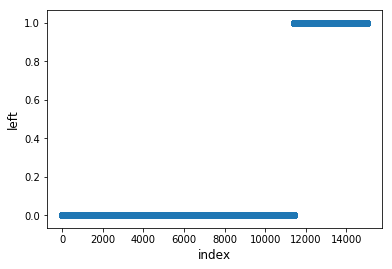

In [6]:
plt.figure(figsize=(6, 4))
plt.scatter(range(dataset.shape[0]), np.sort(dataset.left.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('left', fontsize=12)
plt.show()

Проверим, какие типы признаков у нас есть в датасете:

In [7]:
dtype_df = dataset.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

dtype_df.loc[:10,:]

,Count,Column Type
0,satisfaction_level,float64
1,last_evaluation,float64
2,number_project,int64
3,average_montly_hours,int64
4,time_spend_company,int64
5,Work_accident,int64
6,left,int64
7,promotion_last_5years,int64
8,sales,object
9,salary,object


В наличии у нас 2 категориальные переменные (sales и salary), остальные являются количественными.

###  Часть 3. Первичный визуальный анализ признаков

Посмотрим на матрицу корреляции для датасета:

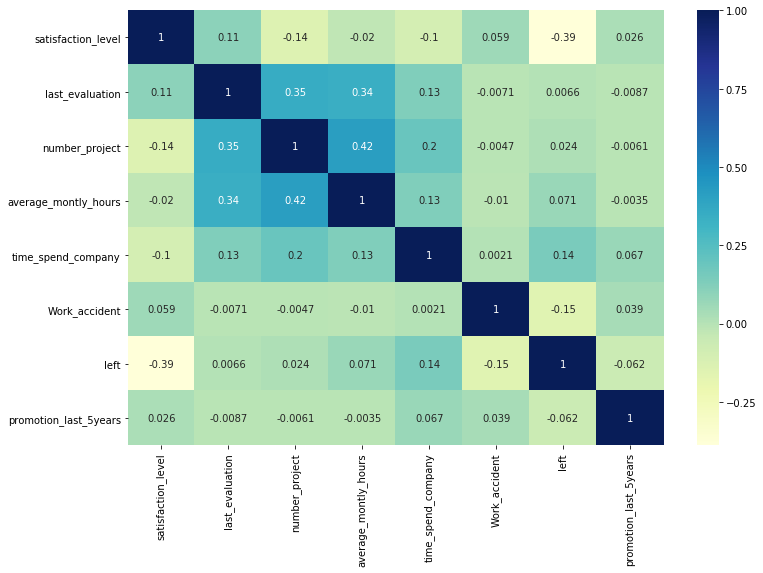

In [8]:
corr = dataset.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="YlGnBu")

Как видим, сильно корреляции между признаками нет (< 0.7). Считаем, что они линейнонезависимы.

__Пропущенные значения и выбросы отсутствуют (согласно гистрограммам)__

Распределения для признаков имеют вид:

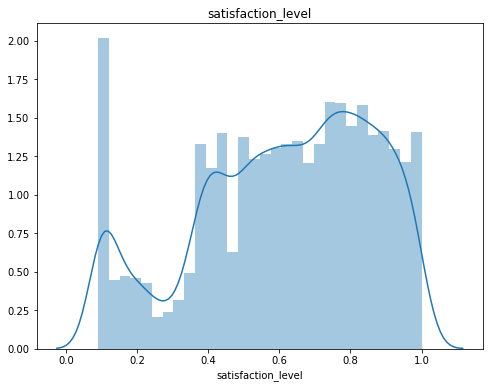

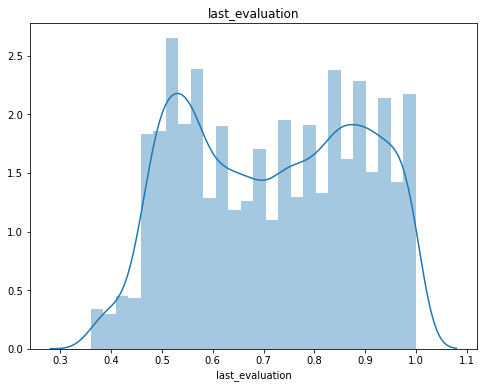

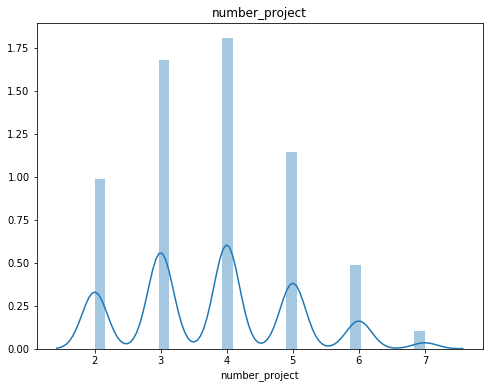

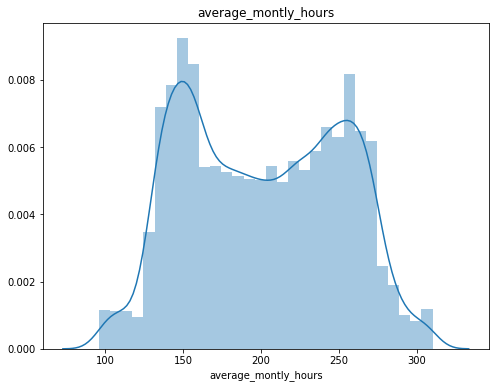

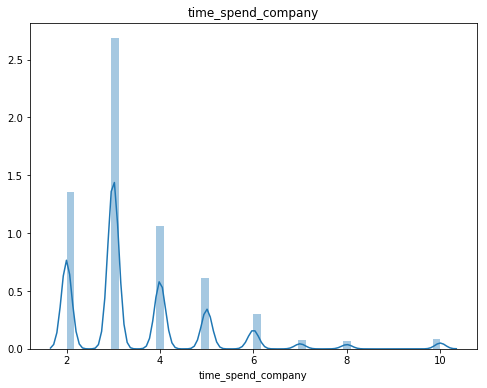

In [9]:
for column in ['satisfaction_level', 'last_evaluation', 'number_project', 
               'average_montly_hours', 'time_spend_company']:
    plt.figure(figsize=(8, 6))
    plt.title(column)
    sns.distplot(dataset[column])
    plt.show()

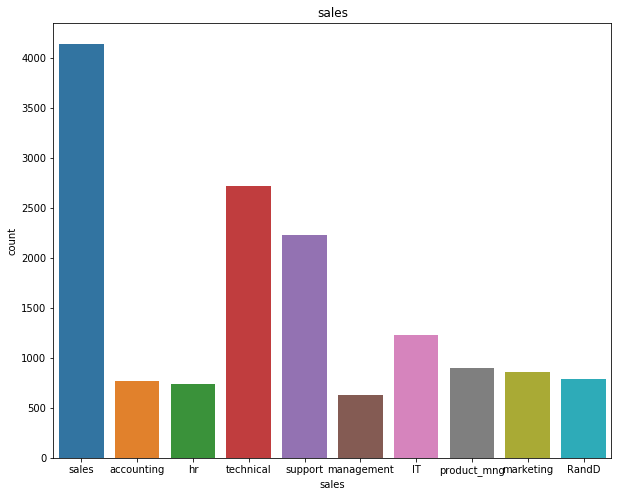

In [10]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(dataset['sales'])
plt.title('sales')
plt.show()

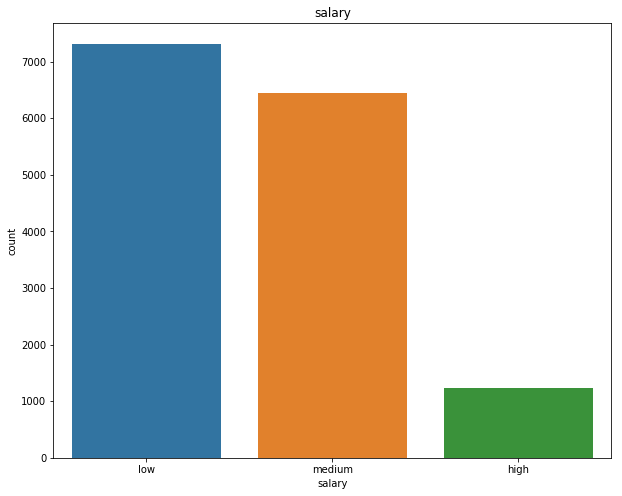

In [11]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(dataset['salary'])
plt.title('salary')
plt.show()

Проведем анализ влияния признаков на целевую переменную:

In [12]:
def plot_distribution(df, var, target, yl=4, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()), ylim=(0, yl))
    facet.add_legend()
    plt.show()

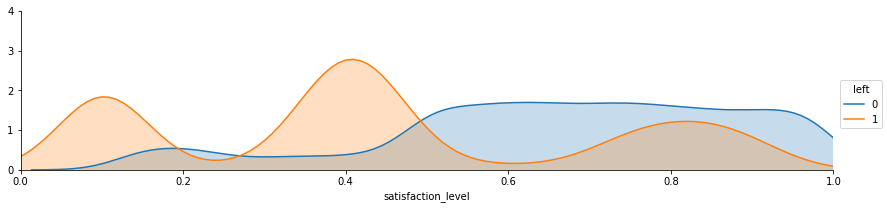

In [13]:
plot_distribution(dataset, 'satisfaction_level', 'left')

Из распределения __satisfaction_level__ видно, что люди часто увольняются, когда уровень удовлетворение мал, в тоже время небольшая часть людей увольняется и при высоком уровне - возможно находят лучше или их переманивают.

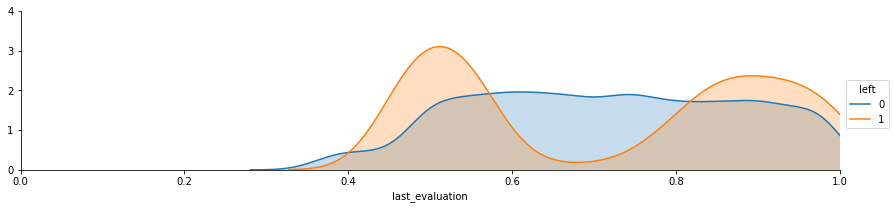

In [14]:
plot_distribution(dataset, 'last_evaluation', 'left')

Из распределения __last_evaluation__ видно люди уходят на другое место если их долго не повышают (есть 2 горба - первый это возле максимального времени пересмотра, второй примерно в середине)

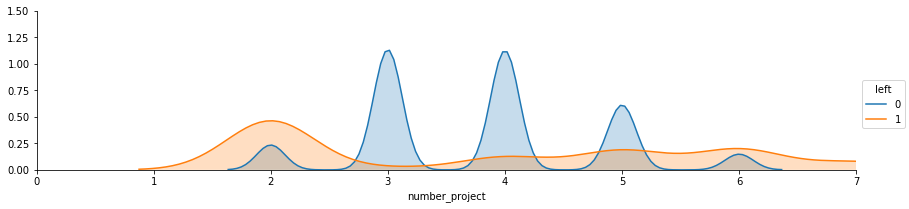

In [15]:
plot_distribution(dataset, 'number_project', 'left', yl=1.5)

Четких закономерностей не видно.

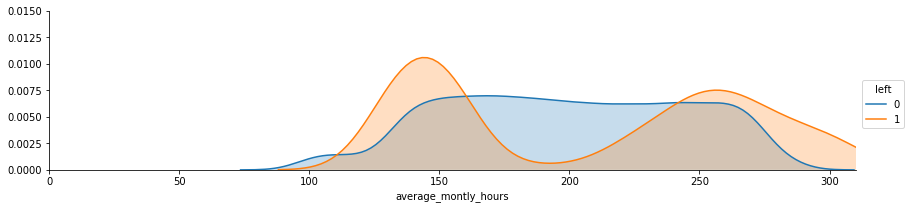

In [16]:
plot_distribution(dataset, 'average_montly_hours', 'left', yl=0.015)

Четких закономерностей не видно: увольняются обычные сотрудники с ~140 часов/мес и в такой же степени трудоголики с 250+ часов.

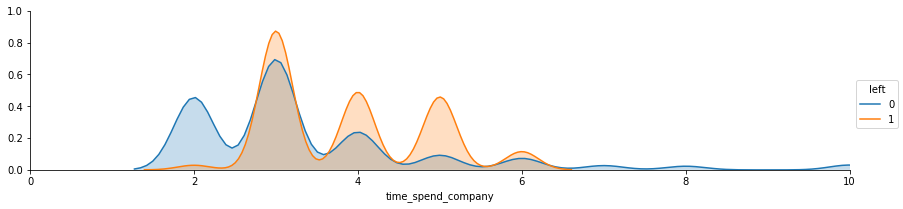

In [17]:
plot_distribution(dataset, 'time_spend_company', 'left', yl=1)

Из распределения __time_spend_company__ видно, что вероятность, того человек уволится растет в течении времени его работы в компании.

###  Часть 4. Закономерности, "инсайты", особенности данных

Построим scatter plot, предварительно преобразуя категориальные признаки с помощью LabelEncoder

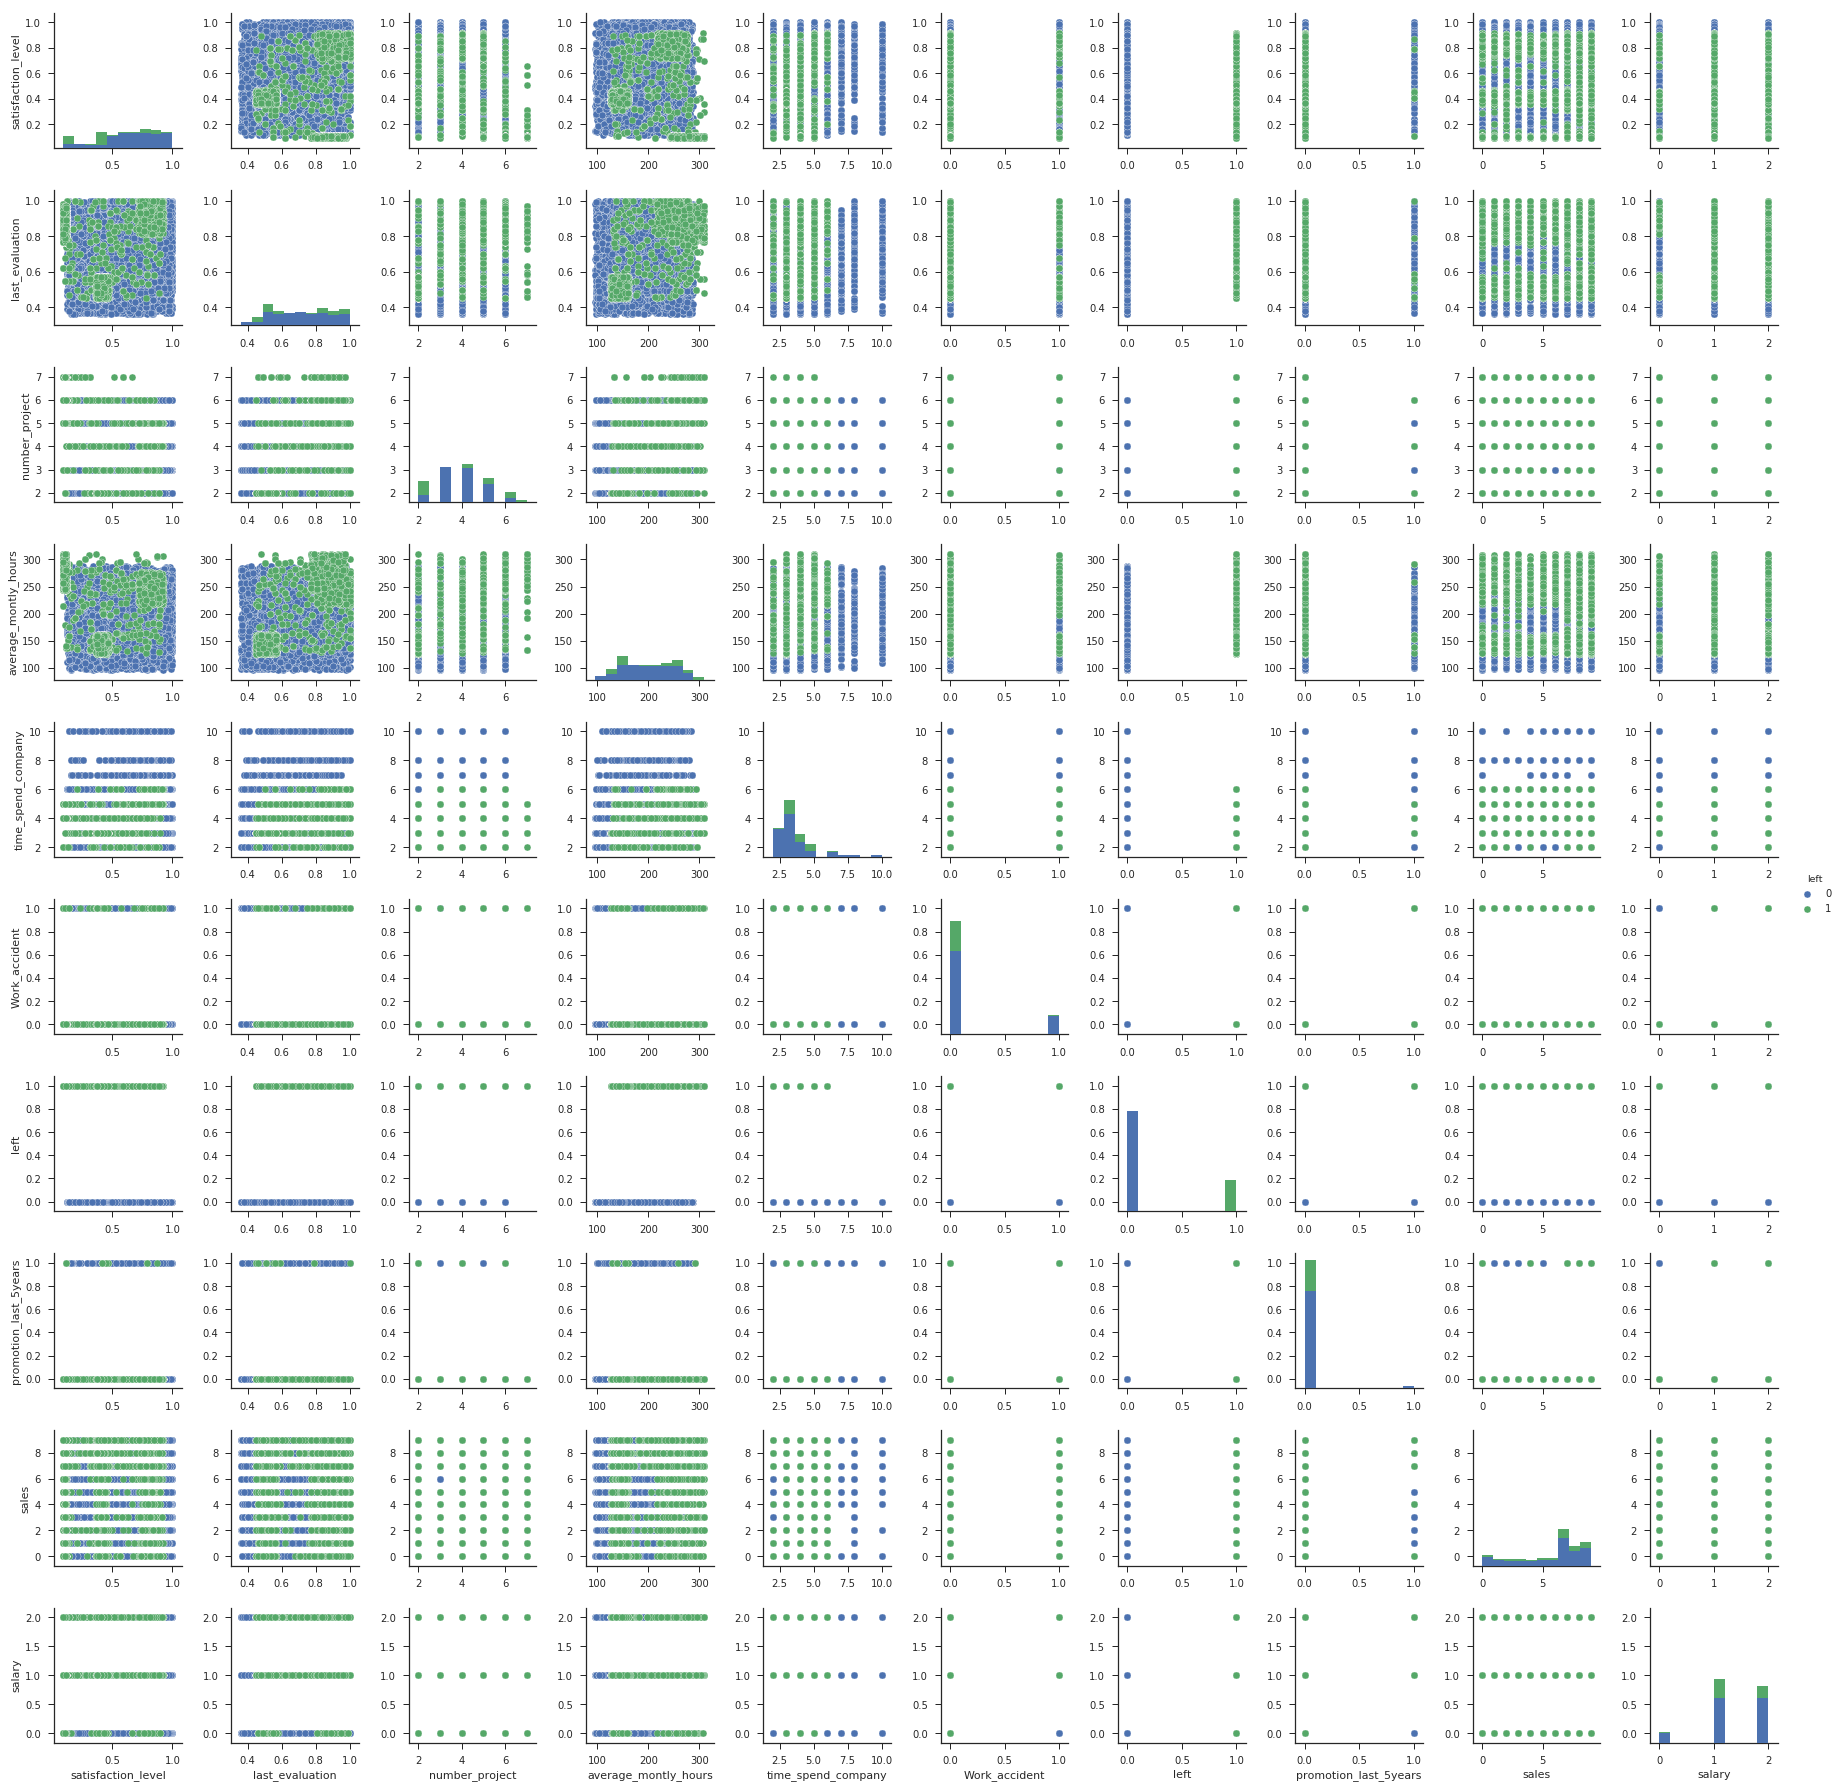

In [18]:
sns.set(style="ticks")

labeled_dataset = dataset.copy()

salary_le = preprocessing.LabelEncoder()
sales_le = preprocessing.LabelEncoder()

labeled_dataset['salary'] = salary_le.fit_transform(labeled_dataset['salary'])
labeled_dataset['sales'] = sales_le.fit_transform(labeled_dataset['sales'])

sns.pairplot(labeled_dataset, hue="left")

Рассмотрим более подробно признаки:

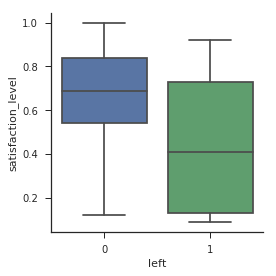

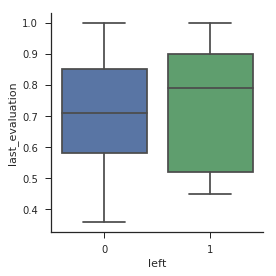

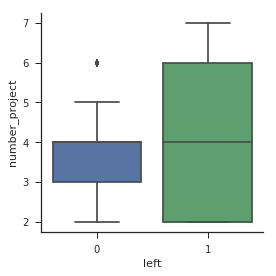

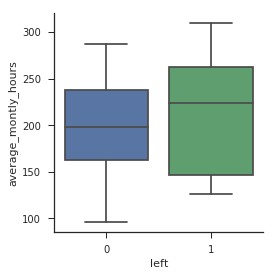

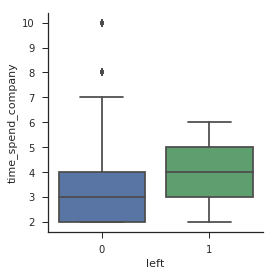

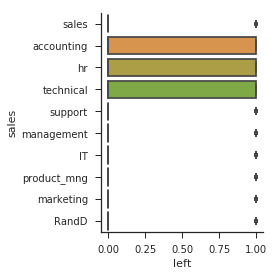

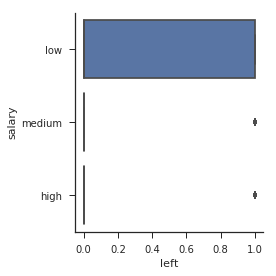

In [19]:
plt.figure(figsize=(12, 10))

sns.factorplot(y="satisfaction_level",x="left",data=dataset,kind="box")
sns.factorplot(y="last_evaluation", x="left", data=dataset, kind="box")
sns.factorplot(y="number_project", x="left", data=dataset, kind="box")
sns.factorplot(y="average_montly_hours", x="left", data=dataset, kind="box")
sns.factorplot(y="time_spend_company", x="left", data=dataset, kind="box")
sns.factorplot(y="sales", x="left", data=dataset, kind="box")
sns.factorplot(y="salary", x="left", data=dataset, kind="box")

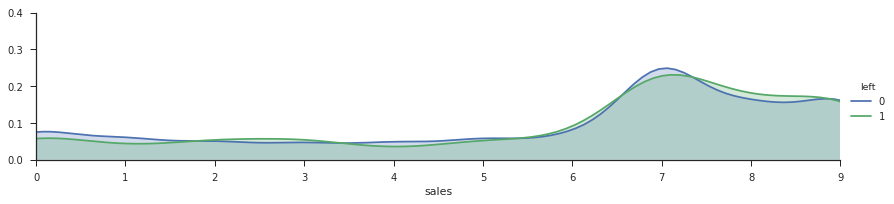

In [20]:
plot_distribution(labeled_dataset, 'sales', 'left', yl=0.4)

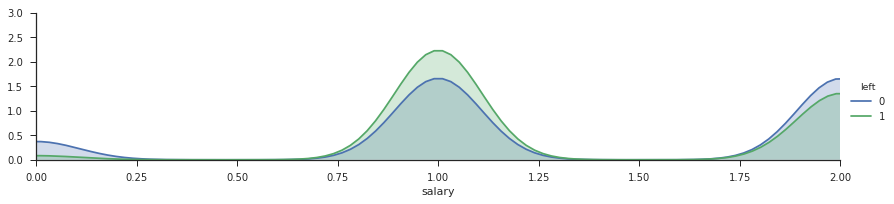

In [21]:
plot_distribution(labeled_dataset, 'salary', 'left', yl=3)

Инсайты:

    - более склонны к увольнениям люди с большим количеством рабочих часов в месяц и уровнем удовлетворенности
    ниже среднего;
    - люди, работающие больше 7 лет, практически не увольняются, вне зависимости от уровня удовлетворенности;
    - среди людей с низким уровнем компенсации высокая текучка;
    - высокое количество увольнений в областях: HR, Accounting, Technical (20% - 30% от всех сотрудников).
    
Общие мысли:

    Важными факторами являются:
        - низкая зарплата;
        - определенный департамент;
        - низкий уровень удовлетворенности;
        - большие переработки;
        - большое количество проектов.
    

###  Часть 7. Предобработка данных 

В качестве кодирование категориальных переменных будет использовать __LabelEncoder__.

Для нормализации датасета используем __StandardScaler__.

In [49]:
salary_le = preprocessing.LabelEncoder()
sales_le = preprocessing.LabelEncoder()

dataset['salary'] = salary_le.fit_transform(dataset['salary'])
dataset['sales'] = sales_le.fit_transform(dataset['sales'])

# может пригодиться
Norma = preprocessing.StandardScaler()
dataset_norm = Norma.fit_transform(dataset)

dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1


Поделим датасет на тренировочную и тестовые выборки (используем ненормированный датасет).<

In [63]:
dataset_v1 = dataset.copy()
y = dataset_v1['left'].values
dataset_v1.drop(['left'], axis=1, inplace=True)
X = dataset_v1.copy()

### Часть. 5. Выбор метрики

В качестве метрики выберем основной __ROC_AUC__, дополнительно будем смотреть __confusion_matrix__.

Задача классификации - предположим, что нас интересуют вероятности (позволяет более точно определять степень уверенности модели). 

Наша целевая переменная не очень сбалансирована, поэтому использовать __accuracy__ выглядит не очень хорошей затеей. 

### Часть. 6. Выбор модели

В качестве пробных моделей проведем отбор с дефолтными параметрами среди следующих моделей:

    - LogisticRegression;
    - RandomForest;
    - XGBoost;
    - CATboost;
    
Все вышеописанные модели вполне применимы для задач бинарной классификации и можно использовать ненормализованный датасет.

In [148]:
clf_lm = LogisticRegression(random_state=42)
preds_lm = cross_val_predict(clf_lm, X, y, cv=5)
print('LogisticRegression: %s ROC AUC' % round(roc_auc_score(y, preds_lm), 4))

clf_rf = RandomForestClassifier(random_state=42)
preds_rf = cross_val_predict(clf_rf, X, y, cv=5)
print('RandomForest      : %s ROC AUC' % round(roc_auc_score(y, preds_rf), 4))

clf_xgb = xgb.XGBClassifier(random_state=42)
preds_xgb = cross_val_predict(clf_xgb, X, y, cv=5)
print('XGBoost           : %s ROC AUC' % round(roc_auc_score(y, preds_xgb), 4))

clf_cat = cat.CatBoostClassifier(random_seed=42)
preds_cat = cross_val_predict(clf_cat, X, y, cv=5)
print('CATBoost          : %s ROC AUC' % round(roc_auc_score(y, preds_cat), 4))

LogisticRegression: 0.5753 ROC AUC
RandomForest      : 0.9831 ROC AUC
XGBoost           : 0.9579 ROC AUC
CATBoost          : 0.9599 ROC AUC


RandomForest в этой задаче показывает впечатляющие результаты. Построим ROC кривую для полученных результатов:

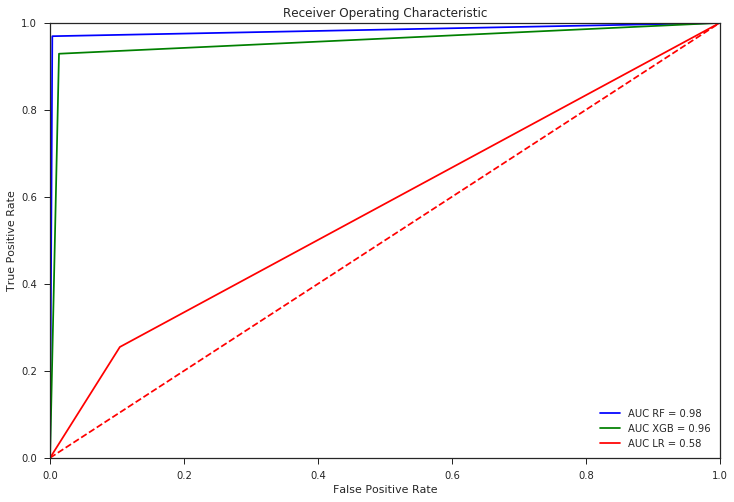

In [149]:
fpr_rf, tpr_rf, threshold = roc_curve(y, preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, threshold = roc_curve(y, preds_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
fpr_lr, tpr_lr, threshold = roc_curve(y, preds_lm)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC RF = %0.2f' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, 'g', label = 'AUC XGB = %0.2f' % roc_auc_xgb)
plt.plot(fpr_lr, tpr_lr, 'r', label = 'AUC LR = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

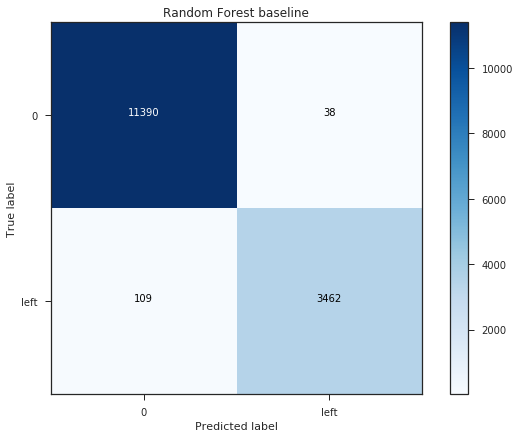

In [150]:
fig_size = [8, 6]
plt.rcParams["figure.figsize"] = fig_size
def plt_matrix(c_matrix, names, title, normalize=False):
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(c_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names)
    plt.yticks(tick_marks, names)
    fmt = '.2f' if normalize else 'd'
    thresh = c_matrix.max() / 2.
    for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
        plt.text(j, i, format(c_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if c_matrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

class_names = ['0', 'left']
baseline_matrix = confusion_matrix(y, preds_rf)
plt_matrix(baseline_matrix, class_names, 'Random Forest baseline')

###  Часть 8. Кросс-валидация, подбор параметров

Проведем поиск оптимальных параметров, посмотрим, получится ли улучшить модель.

Сделаем это следующим образом:

    1. Зафиксируем random_seed (для воспроизведения и равных условий разных моделей);
    2. Будем использовать Stratified разбиения (target не сбалансирован);
        - у нас 15000 записей, будешь разбивать на 5 фолдов.
    3. Подбирать параметры моделей будем с помощью модуля hyperopt.
    4. Описание параметров для тюнинга:
        - n_estimators - количество деревьев в лесу;
        - max_features - количество признаков, используемых для разделения;
        - max_depth    - глубина дерева;
        - class_weight - вес классов.
        Возможно увеличение количество параметров для тюнинга, но вышеописанные параметры являются наиболее 
        важными для модели

Выберем отложенную выборку, на ней мы проверим финальный результат модели:

In [184]:
X_tuning, X_test, y_tuning, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_tuning.shape, X_test.shape, y_tuning.shape, y_test.shape)

(11999, 9) (3000, 9) (11999,) (3000,)


Попробуем сначала class_weight с дефолтными параметрами:

In [185]:
for weight in range(1, 20):
    clf_rf = RandomForestClassifier(class_weight={0: 1, 1: weight}, random_state=42)
    preds_rf = cross_val_predict(clf_rf, X_tuning, y_tuning, cv=5)
    print('RandomForest   %s   : %s ROC AUC' % (weight, round(roc_auc_score(y_tuning, preds_rf), 4)))

RandomForest   1   : 0.9803 ROC AUC
RandomForest   2   : 0.979 ROC AUC
RandomForest   3   : 0.9796 ROC AUC
RandomForest   4   : 0.9796 ROC AUC
RandomForest   5   : 0.9782 ROC AUC
RandomForest   6   : 0.9785 ROC AUC
RandomForest   7   : 0.9784 ROC AUC
RandomForest   8   : 0.9773 ROC AUC
RandomForest   9   : 0.9785 ROC AUC
RandomForest   10   : 0.9789 ROC AUC
RandomForest   11   : 0.978 ROC AUC
RandomForest   12   : 0.9785 ROC AUC
RandomForest   13   : 0.9781 ROC AUC
RandomForest   14   : 0.9786 ROC AUC
RandomForest   15   : 0.9777 ROC AUC
RandomForest   16   : 0.9773 ROC AUC
RandomForest   17   : 0.9775 ROC AUC
RandomForest   18   : 0.9779 ROC AUC
RandomForest   19   : 0.9779 ROC AUC


Вес для значений таргета 1 равный 1 является лучшим. Пока остановимся на нем.

Перейдем к затюниванию модели:

In [189]:
# наиболее простой вариант использования модуля hyperopt
# стоит обратить внимание на факт, что модуль делает 20 случайных подборов параметров до начала настройки.
def hyperopt_train_test(hpparams):
    
    # глобальный счетчик итераций для удобства и вывода информации.
    global counter, result
    counter += 1

    # словарь подбираемых параметров
    params_est = {
        'n_estimators': int(hpparams['n_estimators']),
        'max_features': hpparams['max_features'],
        'max_depth': int(hpparams['max_depth']),
        'random_state': 42,
        'n_jobs': 8,
        'class_weight': {0: 1, 1: 1},
      }

    # код обучения и получения результата метрики:
    clf_rf = RandomForestClassifier(**params_est)
    preds_rf = cross_val_predict(clf_rf, X_tuning, y_tuning, cv=5)
    result_cur = round(roc_auc_score(y_tuning, preds_rf), 6)
    
    if result_cur > result:
        print('Best iteration: %s, roc_auc: %s, params: %s' % (counter, result_cur, hpparams))
        result = result_cur
    return result_cur

# пространство для поиска параметров
# более детально можно ознакомится в документации.
space4dt = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 10),
    'max_features': hp.quniform('max_features', 0.1, 1, 0.1),
    'max_depth': hp.quniform('max_depth', 6, 20, 1),
}

def f(params):
    metrics = hyperopt_train_test(params)
    return {'loss': -metrics, 'status': STATUS_OK}


trials = Trials()
counter, result = 0, 0

best = fmin(f, space4dt, algo=tpe.suggest, max_evals=100, trials=None)
print('best: ', best)

Best iteration: 1, roc_auc: 0.982915, params: {'max_depth': 20.0, 'max_features': 0.6000000000000001, 'n_estimators': 40.0}
Best iteration: 23, roc_auc: 0.98321, params: {'max_depth': 20.0, 'max_features': 0.7000000000000001, 'n_estimators': 60.0}
Best iteration: 49, roc_auc: 0.983451, params: {'max_depth': 19.0, 'max_features': 0.6000000000000001, 'n_estimators': 100.0}
Best iteration: 75, roc_auc: 0.983669, params: {'max_depth': 20.0, 'max_features': 0.5, 'n_estimators': 100.0}
best:  {'max_depth': 20.0, 'max_features': 0.5, 'n_estimators': 100.0}


Лучшие параметры (мы уперлись в 2 границы, значит улучшать еще есть куда, даже для этих параметров):

In [233]:
clf_rf = RandomForestClassifier(max_depth=20, max_features=0.5, n_estimators=100, random_state=42)
preds_rf = cross_val_predict(clf_rf, X, y, cv=5)
print('RandomForest      : %s ROC AUC' % round(roc_auc_score(y, preds_rf), 4))


clf_rf = RandomForestClassifier(max_depth=20, max_features=0.5, n_estimators=100, random_state=42)
preds_rf = clf_rf.fit(X_tuning, y_tuning)

# отложенная выборка
print('RandomForest test : %s ROC AUC' % round(roc_auc_score(y_test, clf_rf.predict(X_test)), 4))

RandomForest      : 0.9859 ROC AUC
RandomForest test : 0.9823 ROC AUC


Для желающих - можно расширить пространство признаков и их значений. Будете служить богу вычислений :)

###  Часть 6. Создание новых признаков и описание этого процесса

Итак, логически (поэтому и не совпадают номера глав) мы подошли генерации фичей (признаков). 

Предлагаю попробовать автоматическую генерацию линейных комбинаций признаков. Можно сгенерировать на первый вгляд логичные признаки, но все они попадут в наше поле зрения при генерации.

Что мы имеем сейчас:

In [187]:
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1


Сгенерируем много много признаков:

In [320]:
dataset_generated = dataset.copy()
print('\nBefore transformation: ', dataset_generated.shape)
columns = [
    'satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours',
    'time_spend_company', 'salary'
]
for i1, col1 in enumerate(columns):
    for i2, col2 in enumerate(columns):
        if col1 == col2:
            dataset_generated['%s_%s_0' % (col1, col2)] = np.log(X[col1] + 1)     
        
        dataset_generated['%s_%s_1' % (col1, col2)] = X[col1] / (X[col2] + 1)
        dataset_generated['%s_%s_2' % (col1, col2)] = X[col1] * X[col2]
print('\nAfter transformation: ', dataset_generated.shape)


Before transformation:  (14999, 10)

After transformation:  (14999, 88)


Теперь проведем отбор признаков. Для этого воспользуемся или самописным жадным отбором или уже написанным для нас в пакете __mlxtend__. Используем вот такой вариант отбора - SequentialFeatureSelector (есть несколько вариантов, можно почитать документацию по пакету). Наш вариант добавляет по одному признаку в датасет, и выбирает лучшую комбинацию по достижению максимального количества признаков. Для нашей задачи давайте установим максимальное значение признаков равное 12 и минимальное 1.

In [321]:
y_sfs = dataset_generated['left'].values
dataset_generated.drop(['left'], axis=1, inplace=True)
X_sfs = dataset_generated.copy()

model = RandomForestClassifier(random_state=42)
sfs1 = SFS(model, k_features=(1, 12), forward=True, floating=False,
           verbose=2, scoring='roc_auc', cv=3, n_jobs=-1)
sfs1 = sfs1.fit(X_sfs.as_matrix(), y_sfs)

[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  72 out of  87 | elapsed:    2.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    2.7s finished
Features: 1/12[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    2.9s finished
Features: 2/12[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    3.2s finished
Features: 3/12[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    4.2s finished
Features: 4/12[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    4.3s finished
Features: 5/12[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    4.7s finished
Features: 6/12[Parallel(n_jobs=-1)]: Done  34 tasks

In [330]:
print('Results:')
print(sfs1.k_feature_idx_)
print(sfs1.k_score_)

Results:
(66, 5, 37, 43, 47, 80, 54, 23, 28, 61, 62, 63)
0.992498370333


Собирем датасет только из отобранных фич:

In [331]:
dataset_best_features = pd.DataFrame()
columns = []
for elem in sfs1.k_feature_idx_:
    dataset_best_features[dataset_generated.columns[elem]] = dataset_generated[dataset_generated.columns[elem]]
dataset_best_features['left'] = y_sfs
dataset_best_features.head()

,time_spend_company_number_project_2,Work_accident,number_project_last_evaluation_1,number_project_average_montly_hours_2,number_project_salary_2,salary_average_montly_hours_1,average_montly_hours_average_montly_hours_0,last_evaluation_satisfaction_level_2,last_evaluation_number_project_2,time_spend_company_satisfaction_level_1,time_spend_company_satisfaction_level_2,time_spend_company_last_evaluation_1,left
0,6,0,1.307190,314,2,0.006329,5.062595,0.2014,1.06,2.173913,1.14,1.960784,1
1,30,0,2.688172,1310,10,0.007605,5.572154,0.6880,4.30,3.333333,4.80,3.225806,1
2,28,0,3.723404,1904,14,0.007326,5.609472,0.0968,6.16,3.603604,0.44,2.127660,1
3,25,0,2.673797,1115,5,0.004464,5.411646,0.6264,4.35,2.906977,3.60,2.673797,1
4,6,0,1.315789,318,2,0.006250,5.075174,0.1924,1.04,2.189781,1.11,1.973684,1


Попробуем еще раз затюнить параметры модели для полученного датасета:

In [332]:
y_best = dataset_best_features['left'].values
dataset_best_features.drop(['left'], axis=1, inplace=True)
X_best = dataset_best_features.copy()

X_tuning_b, X_test_b, y_tuning_b, y_test_b = train_test_split(
    X_best, y_best, test_size=0.2, random_state=42, stratify=y)
print(X_tuning.shape, X_test.shape, y_tuning.shape, y_test.shape)

(11999, 9) (3000, 9) (11999,) (3000,)


In [333]:
clf_rf = RandomForestClassifier(random_state=42)
preds_rf = cross_val_predict(clf_rf, X_best, y_best, cv=5)
print('RandomForest      : %s ROC AUC' % round(roc_auc_score(y_best, preds_rf), 4))

RandomForest      : 0.9829 ROC AUC


Как видим, добавление и отбор признаков в нашем случае не помог, значение целевой метрики уходшилось, попробуем исправить ситуацию тюнингом параметров модели:

In [339]:
# наиболее простой вариант использования модуля hyperopt
# стоит обратить внимание на факт, что модуль делает 20 случайных подборов параметров до начала настройки.
def hyperopt_train_test(hpparams):
    
    # глобальный счетчик итераций для удобства и вывода информации.
    global counter, result
    counter += 1

    # словарь подбираемых параметров
    params_est = {
        'n_estimators': int(hpparams['n_estimators']),
        'max_features': hpparams['max_features'],
        'max_depth': int(hpparams['max_depth']),
        'random_state': 42,
        'n_jobs': 8,
        'class_weight': {0: 1, 1: 1},
      }

    # код обучения и получения результата метрики:
    clf_rf = RandomForestClassifier(**params_est)
    preds_rf = cross_val_predict(clf_rf, X_best, y_best, cv=5)
    result_cur = round(roc_auc_score(y_best, preds_rf), 6)
    
    if result_cur > result:
        print('Best iteration: %s, roc_auc: %s, params: %s' % (counter, result_cur, hpparams))
        result = result_cur
    return result_cur

# пространство для поиска параметров
# более детально можно ознакомится в документации.
space4dt = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 10),
    'max_features': hp.quniform('max_features', 0.1, 1, 0.1),
    'max_depth': hp.quniform('max_depth', 6, 24, 1),
}

def f(params):
    metrics = hyperopt_train_test(params)
    return {'loss': -metrics, 'status': STATUS_OK}


trials = Trials()
counter, result = 0, 0

best = fmin(f, space4dt, algo=tpe.suggest, max_evals=200, trials=None)
print('best: ', best)

Best iteration: 1, roc_auc: 0.956718, params: {'max_depth': 7.0, 'max_features': 0.7000000000000001, 'n_estimators': 70.0}
Best iteration: 2, roc_auc: 0.982971, params: {'max_depth': 17.0, 'max_features': 0.5, 'n_estimators': 180.0}
Best iteration: 4, roc_auc: 0.985062, params: {'max_depth': 19.0, 'max_features': 0.4, 'n_estimators': 50.0}
Best iteration: 15, roc_auc: 0.985797, params: {'max_depth': 22.0, 'max_features': 0.30000000000000004, 'n_estimators': 180.0}
Best iteration: 22, roc_auc: 0.986025, params: {'max_depth': 23.0, 'max_features': 0.30000000000000004, 'n_estimators': 150.0}
Best iteration: 29, roc_auc: 0.986138, params: {'max_depth': 22.0, 'max_features': 0.5, 'n_estimators': 160.0}
Best iteration: 32, roc_auc: 0.986165, params: {'max_depth': 23.0, 'max_features': 0.7000000000000001, 'n_estimators': 190.0}
Best iteration: 47, roc_auc: 0.986217, params: {'max_depth': 22.0, 'max_features': 0.4, 'n_estimators': 160.0}
Best iteration: 93, roc_auc: 0.986235, params: {'max_dep

In [338]:
clf_rf = RandomForestClassifier(max_depth=22, max_features=0.8, n_estimators=110, random_state=42)
clf_rf.fit(X_tuning_b, y_tuning_b)

# отложенная выборка
print('RandomForest test : %s ROC AUC' % round(roc_auc_score(y_test_b, clf_rf.predict(X_test_b)), 4))

clf_rf = RandomForestClassifier(max_depth=22, max_features=0.8, n_estimators=110, random_state=42)
preds_rf = cross_val_predict(clf_rf, X_best, y_best, cv=5)
print('RandomForest      : %s ROC AUC' % round(roc_auc_score(y_best, preds_rf), 4))

clf_rf = RandomForestClassifier(max_depth=22, max_features=0.8, n_estimators=110, random_state=42)
preds_rf = cross_val_predict(clf_rf, X_best, y_best, cv=5)
print('RandomForest      : %s ROC AUC' % round(roc_auc_score(y_best, preds_rf), 4))

RandomForest test : 0.9803 ROC AUC
RandomForest      : 0.986 ROC AUC


Тюнинг модели улучшил результат, возможно нужно большее пространство параметров и больше степеней свободы (добавить параметры модели). Результаты получились на исходном датасете с улучшенными параметрами __hyperopt__:

    RandomForest      : 0.9859 ROC AUC (исходный датасет);
    RandomForest      : 0.986 ROC AUC (переработанные признаки в датасете);

###  Часть 8. Построение кривых валидации и обучения 

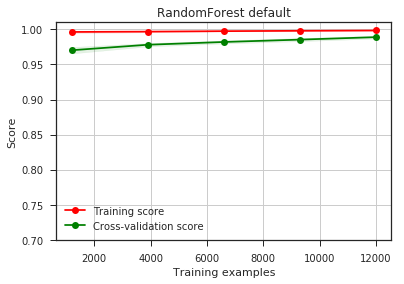

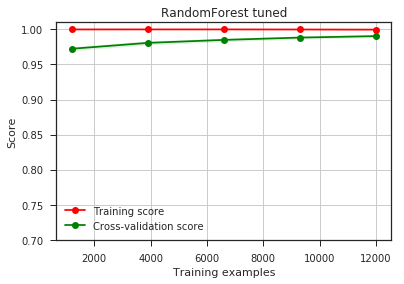

In [343]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "RandomForest default"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(random_state=42)
plot_learning_curve(estimator, title, X_best, y, ylim=(0.7, 1.01), cv=cv, n_jobs=8)

title = "RandomForest tuned"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(max_depth=20, max_features=0.5, n_estimators=100, random_state=42)
plot_learning_curve(estimator, title, X_best, y, (0.7, 1.01), cv=cv, n_jobs=8)

plt.show()

Модель достаточно хорошо сходится, хотя еще данные бы не помешали.

###  Часть 9. Прогноз для тестовой или отложенной выборки

Проверим __confusion_matrix__ для новых параметров:

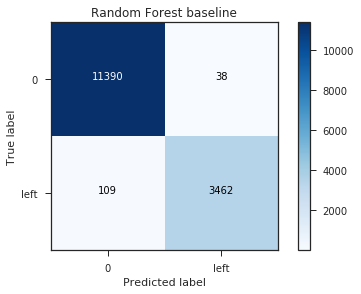

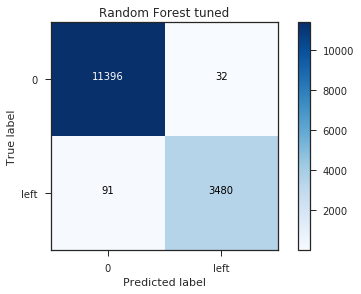

In [344]:
clf_rf = RandomForestClassifier(max_depth=20, max_features=0.5, n_estimators=100, random_state=42)
preds_rf_tuned = cross_val_predict(clf_rf, X_best, y, cv=5)
tuned_matrix = confusion_matrix(y, preds_rf_tuned)

clf_rf = RandomForestClassifier(random_state=42)
preds_rf_baseline = cross_val_predict(clf_rf, X, y, cv=5)
baseline_matrix = confusion_matrix(y, preds_rf_baseline)

plt_matrix(baseline_matrix, class_names, 'Random Forest baseline')
plt_matrix(tuned_matrix, class_names, 'Random Forest tuned')
plt.show()

Как видно выше по проекту, отложенной выборкой мы несколько раз пользовались для оценки качества модели.

###  Часть 10. Оценка модели с описанием выбранной метрики

Выбранная метрика ROC_AUC близка к 1. Наша модель практически не ошибается и уверена в своих вероятностях. Как видно из confusion matrix в пункте 9. Модель неправильно идентифицирует всего 123 человек. Accuracy модели > 99%.

### Часть 11. Выводы 

1. Мы отобрали наиболее хорошо подходящую модель.
2. Провели тюнинг фичей
3. Попробовали сгенерировать фичи и сравнили модели между собой.
4. Получили лучшую модель.